In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

# Problem 1

IVP

$$
\dot{y} = y + 8 y^2 - 9 y^3,\,y(0) = \frac{1}{2}
$$

Implicit form of solution

$$
\int_{\frac{1}{2}}^{y(t)} dy \frac{1}{y + 8 y^2 - 9 y^3} = t
$$

$$
-\frac{1}{10}\log(1 - y(t)) + \log(y(t)) - \frac{9}{10}\log(9y(t)+1) + \frac{9}{10}\log(11) = t
$$

For Newton's method

$$
F(y) = -\frac{1}{10}\log(1 - y) + \log(y) - \frac{9}{10}\log(9y+1) + \frac{9}{10}\log(11) - t = 0,
$$

$$
F^{'} = \frac{1}{10}\frac{1}{1-y} + \frac{1}{y} - \frac{81}{10}\frac{1}{9y + 1}
$$

We start by coding exact solution with Newton's method.

In [2]:
def f(y, t):
    return y + 8*y**2 - 9*y**3

def F(y, t):
    return -np.log(1-y)/10 + np.log(y) - 9*np.log(9*y+1)/10 + 9*np.log(11)/10 - t

def dF(y):
    return 1/(1-y)/10 + 1/y - 81/(9*y+1)/10

def Newton(y, t, N_it):
    for _ in range(N_it):
        y = y - F(y, t) / dF(y)
    return y

def get_exact_solution(T, N_it):
    Y = [1/2, ]
    for t in T[1:]:
        y = Y[-1]
        y = Newton(y, t, N_it)
        Y.append(y)
    Y = np.array(Y)
    return Y

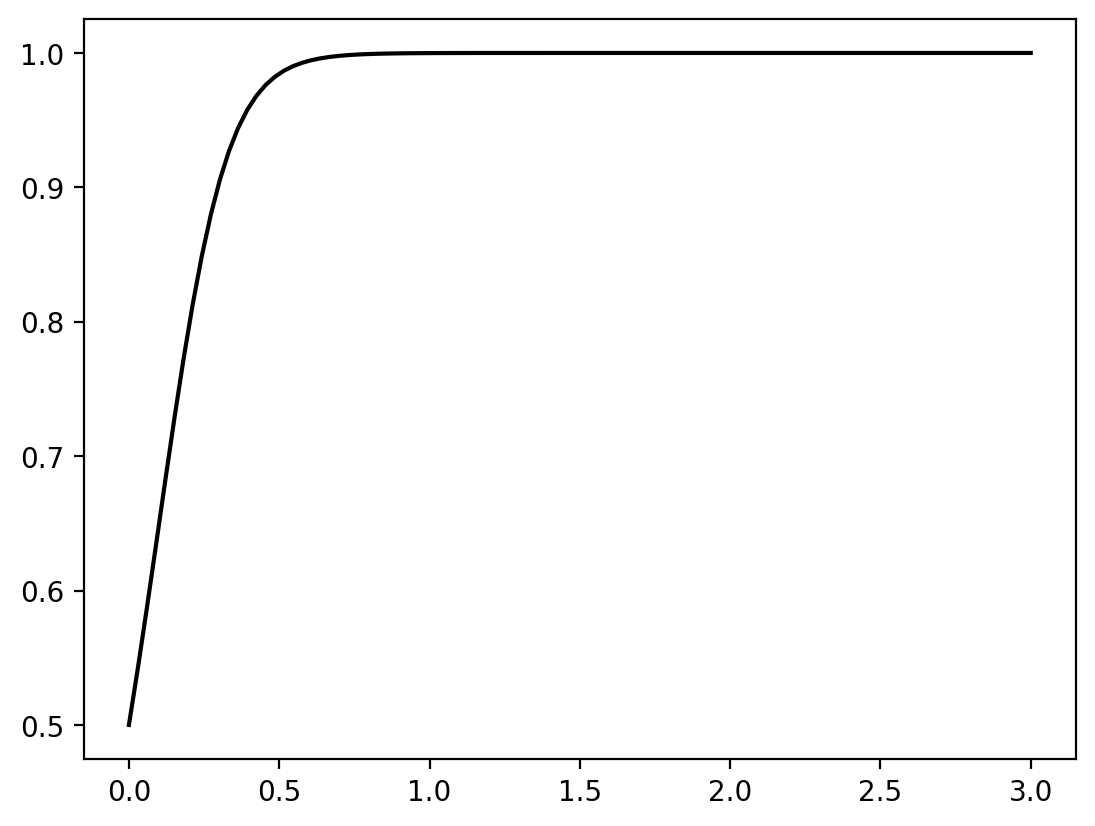

In [3]:
N_t = 100
N_it = 10
t = np.linspace(0, 3, N_t)
exact_solution = get_exact_solution(t, N_it)

plt.plot(t, exact_solution, color="black");

Now we implement integrators.

In [4]:
def Euler(y, t, dt, F):
    return y + dt*F(y, t)

def midpoint(y, t, dt, F):
    return y + dt*F(y + dt*F(y, t)/2, t + dt/2)

def RK4(y, t, dt, F):
    k1 = F(y, t)
    k2 = F(y + dt*k1/2, t+dt/2)
    k3 = F(y + dt*k2/2, t+dt/2)
    k4 = F(y + dt*k3, t + dt)
    return y + dt*(k1 + 2*k2 + 2*k3 + k4)/6

def solve_by_method(y, T, F, method):
    Y = [y, ]
    dt = T[1] - T[0]
    for t in T[1:]:
        y = method(Y[-1], t, dt, F)
        Y.append(y)
    Y = np.array(Y)
    return Y

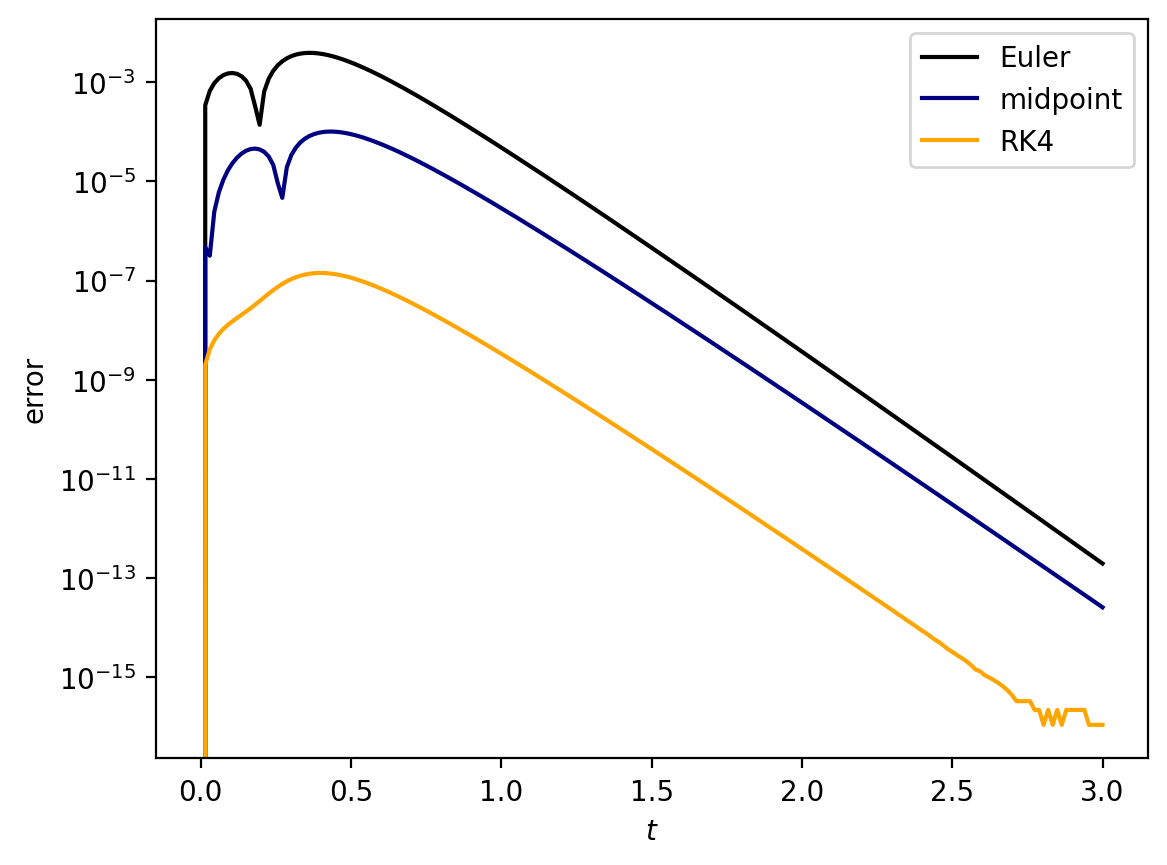

In [5]:
# simple implementation check

N_t = 200
N_it = 10
y0 = 1/2
t = np.linspace(0, 3, N_t)
exact_solution = get_exact_solution(t, N_it)
Euler_solution = solve_by_method(y0, t, f, Euler)
midpoint_solution = solve_by_method(y0, t, f, midpoint)
RK4_solution = solve_by_method(y0, t, f, RK4)

plt.plot(t, np.abs(Euler_solution - exact_solution), color="black", label="Euler")
plt.plot(t, np.abs(midpoint_solution - exact_solution), color="navy", label="midpoint")
plt.plot(t, np.abs(RK4_solution - exact_solution), color="orange", label="RK4")
plt.legend()
plt.yscale("log")
plt.xlabel("$t$")
plt.ylabel("error");

To study local error we will compute
$$
e_{\text{local}} = \left|y(\Delta t) - \widetilde{y}(\Delta t)\right|,
$$
where $y(\Delta t)$ and $\widetilde{y}(\Delta t)$ are exact and approximate solutions.

For global error we will take
$$
e_{\text{global}} = \left|y(1) - \widetilde{y}(1)\right|.
$$

In [6]:
H = [0.5, 0.3, 0.1, 0.03, 0.05, 0.01, 0.003, 0.005, 0.001, 0.0005]
N = np.array([int(1/h) for h in H])

methods = {
    "Euler": Euler,
    "midpoint": midpoint,
    "RK4": RK4
}

local_errors = {key:[] for key in methods.keys()}
global_errors = {key:[] for key in methods.keys()}

N_it = 10
y0 = 1/2

N_global = 500
t_ = np.linspace(0, 1, N_global)
exact_global = get_exact_solution(t_, N_it)[-1]

for N_t in N:
    t = np.linspace(0, 1, N_t)
    t_ = np.linspace(0, t[1], 100)
    exact_local = get_exact_solution(t_, N_it)[-1]
    for method in methods.keys():
        sol = solve_by_method(y0, t, f, methods[method])
        local_errors[method].append(np.abs(sol[1] -  exact_local))
        global_errors[method].append(np.abs(sol[-1] - exact_global))

H = 1/N

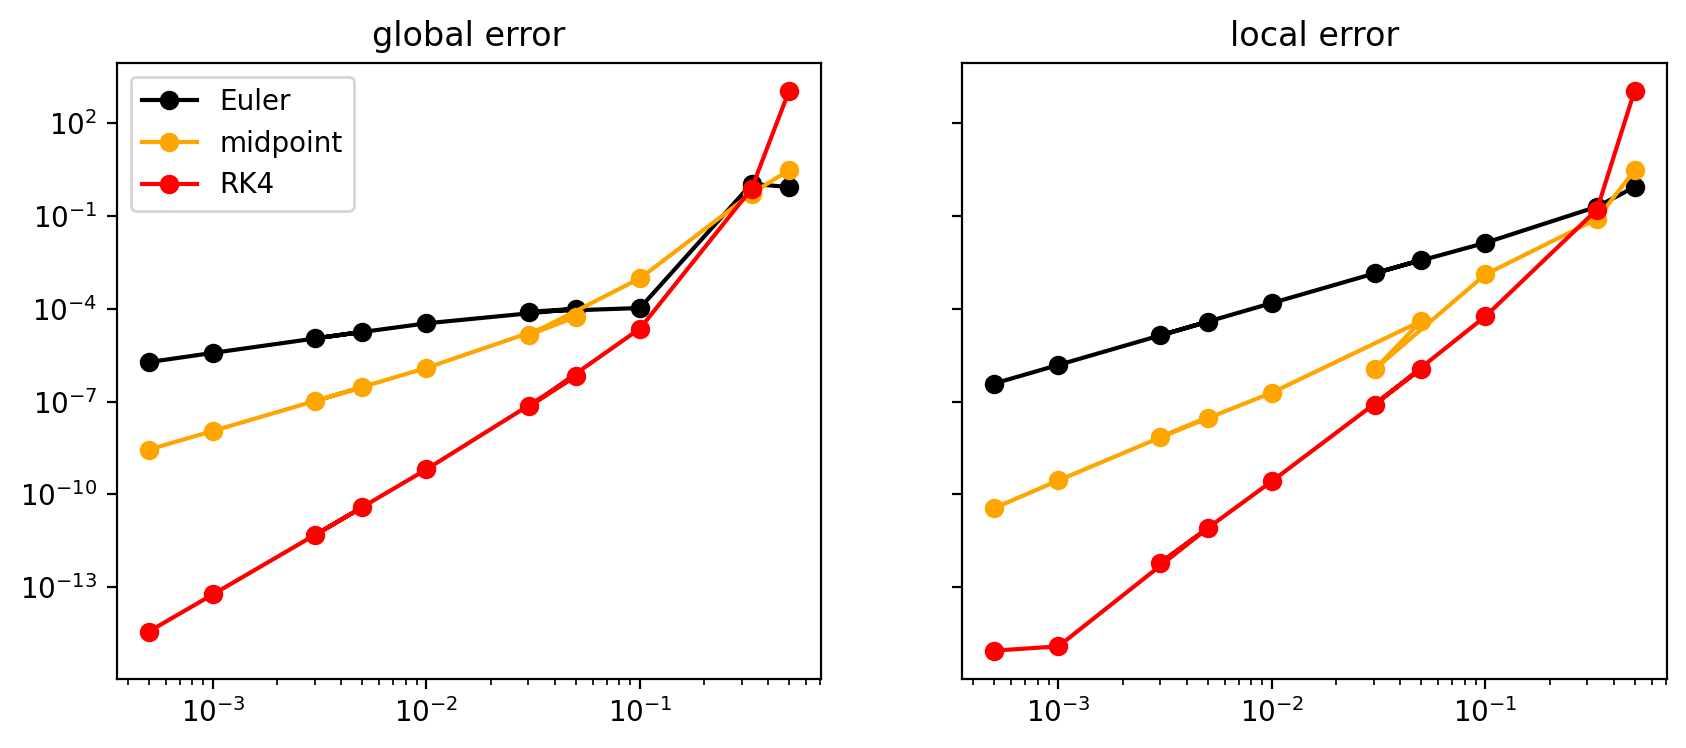

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for method, color in zip(methods.keys(), ["black", "orange", "red"]):
    ax[0].plot(H, global_errors[method], "o-", color=color, label=method)

for method, color in zip(methods.keys(), ["black", "orange", "red"]):
    ax[1].plot(H, local_errors[method], "o-", color=color)

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")

ax[0].legend()
ax[0].set_title("global error")
ax[1].set_title("local error");

To estimate slopes we take two points $i$ and $j$ and compute

$$
\frac{\log e_i - \log e_j}{\log h_i - log h_j} = \frac{\log \left(\frac{e_i}{e_j}\right)}{\log \left(\frac{h_i}{h_j}\right)}.
$$

Local errors come from truncation of Taylor series, so we expect

|method|local error|order|
|:--:|:--:|:--:|
|Euler|$h^2$|$2$|
|Midpoint|$h^3$|$3$|
|RK4|$h^5$|$5$|

Global error (for ODE with Lipschitz $F(\cdot, t)$) is expected to deteriorate by one order

|method|global error|order|
|:--:|:--:|:--:|
|Euler|$h$|$1$|
|Midpoint|$h^2$|$2$|
|RK4|$h^4$|$4$|

In [8]:
for method in methods.keys():
    ord = np.log(local_errors[method][-4]/local_errors[method][-5]) / np.log(H[-4]/H[-5])
    print(method, "local error order", ord)

Euler local error order 2.002168129151945
midpoint local error order 2.7476263117366084
RK4 local error order 5.045572797670923


In [9]:
for method in methods.keys():
    ord = np.log(global_errors[method][-4]/global_errors[method][-5]) / np.log(H[-4]/H[-5])
    print(method, "global error order", ord)

Euler global error order 0.9347900914926159
midpoint global error order 2.0576501907626095
RK4 global error order 4.069559803567768


Numerical estimations align well with theory. It is important to note that theoretical results are correct only asymptotically, meaning they hold when $\Delta t\rightarrow 0$. Nonetheless we see a decent agreement event for large $\Delta t$.

# Problem 2

Implicit Euler method for ODE $\dot{x} = F(x, t)$ reads
$$
x_{n+1} - x_{n} - \Delta t F(x_{n+1}, t_{n+1}) = 0.
$$

To solve nonlinear euqation above we can use fixed-point iterations
\begin{equation}
  \begin{split}
    x^{(0)} &= x_{n}\\
    x^{(i+1)} &= x_{n} + \Delta t F(x^{(i)}, t_{n+1})
  \end{split}
\end{equation}

or Newton's method
\begin{equation}
  \begin{split}
    x^{(0)} &= x_{n},\\
    x^{(i+1)} &= x^{(i)} - \left(I - \Delta t\left.\frac{\partial F}{\partial x}\right\|_{x = x^{(i)},\,t=t_{n+1}}\right)^{-1}\left(x^{(i)} - x_{n} - \Delta t F(x^{(i)}, t_{n+1})\right).
  \end{split}
\end{equation}

Implementation below is for scalar equation.

We also need trapezoid method:
$$
x_{n+1} - x_{n} - \frac{\Delta t}{2} \left(F(x_{n+1}, t_{n+1}) + F(x_{n}, t_{n})\right) = 0.
$$

It is straighforward to modify implicit Euler implementation to code trapezoid method.

In [10]:
def f(y, t):
    return y + 8*y**2 - 9*y**3

def df(y, t):
    return 1 + 16*y - 27*y**2

def implicit_Euler_fp(y, t, dt, F, N_it):
    y_ = y
    for _ in range(N_it):
        y_ = y + dt * F(y_, t+dt)
    return y_

def trapezoid_fp(y, t, dt, F, N_it):
    y_ = y
    for _ in range(N_it):
        y_ = y + dt * (F(y_, t+dt) + F(y, t)) / 2
    return y_

def implicit_Euler_Newton(y, t, dt, F, dF, N_it):
    y_ = y
    for _ in range(N_it):
        y_ = y_ - (y_ - y - dt*F(y_, t + dt)) / (1 - dt*dF(y_, t+ dt))
    return y_

def trapezoid_Newton(y, t, dt, F, dF, N_it):
    y_ = y
    for _ in range(N_it):
        y_ = y_ - (y_ - y - dt*F(y_, t + dt)/2 - dt*F(y, t)/2) / (1 - dt*dF(y_, t+ dt)/2)
    return y_

In [11]:
H = [0.5, 0.3, 0.1, 0.03, 0.05, 0.01, 0.003, 0.005, 0.001, 0.0005]
N = np.array([int(1/h) for h in H])

N_fixed_point_it = 10
N_Newton_it = 10

methods = {
    "Euler": Euler,
    "midpoint": midpoint,
    "RK4": RK4,
    "implicit Euler (fixed point)": lambda y, t, dt, F: implicit_Euler_fp(y, t, dt, F, N_fixed_point_it),
    "implicit Euler (Newton)": lambda y, t, dt, F: implicit_Euler_Newton(y, t, dt, F, df, N_Newton_it),
    "trapezoid (fixed point)": lambda y, t, dt, F: trapezoid_fp(y, t, dt, F, N_fixed_point_it),
    "trapezoid (Newton)": lambda y, t, dt, F: trapezoid_Newton(y, t, dt, F, df, N_Newton_it),
}

local_errors = {key:[] for key in methods.keys()}
global_errors = {key:[] for key in methods.keys()}

N_it = 10
y0 = 1/2

N_global = 500
t_ = np.linspace(0, 1, N_global)
exact_global = get_exact_solution(t_, N_it)[-1]

for N_t in N:
    t = np.linspace(0, 1, N_t)
    t_ = np.linspace(0, t[1], 100)
    exact_local = get_exact_solution(t_, N_it)[-1]
    for method in methods.keys():
        sol = solve_by_method(y0, t, f, methods[method])
        local_errors[method].append(np.abs(sol[1] -  exact_local))
        global_errors[method].append(np.abs(sol[-1] - exact_global))

H = 1/N

<ipython-input-10-ebdfab81a85c>:2: RuntimeWarning: overflow encountered in scalar power
  return y + 8*y**2 - 9*y**3
<ipython-input-10-ebdfab81a85c>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return y + 8*y**2 - 9*y**3


First we simply run code from Problem 1 to compare methods.

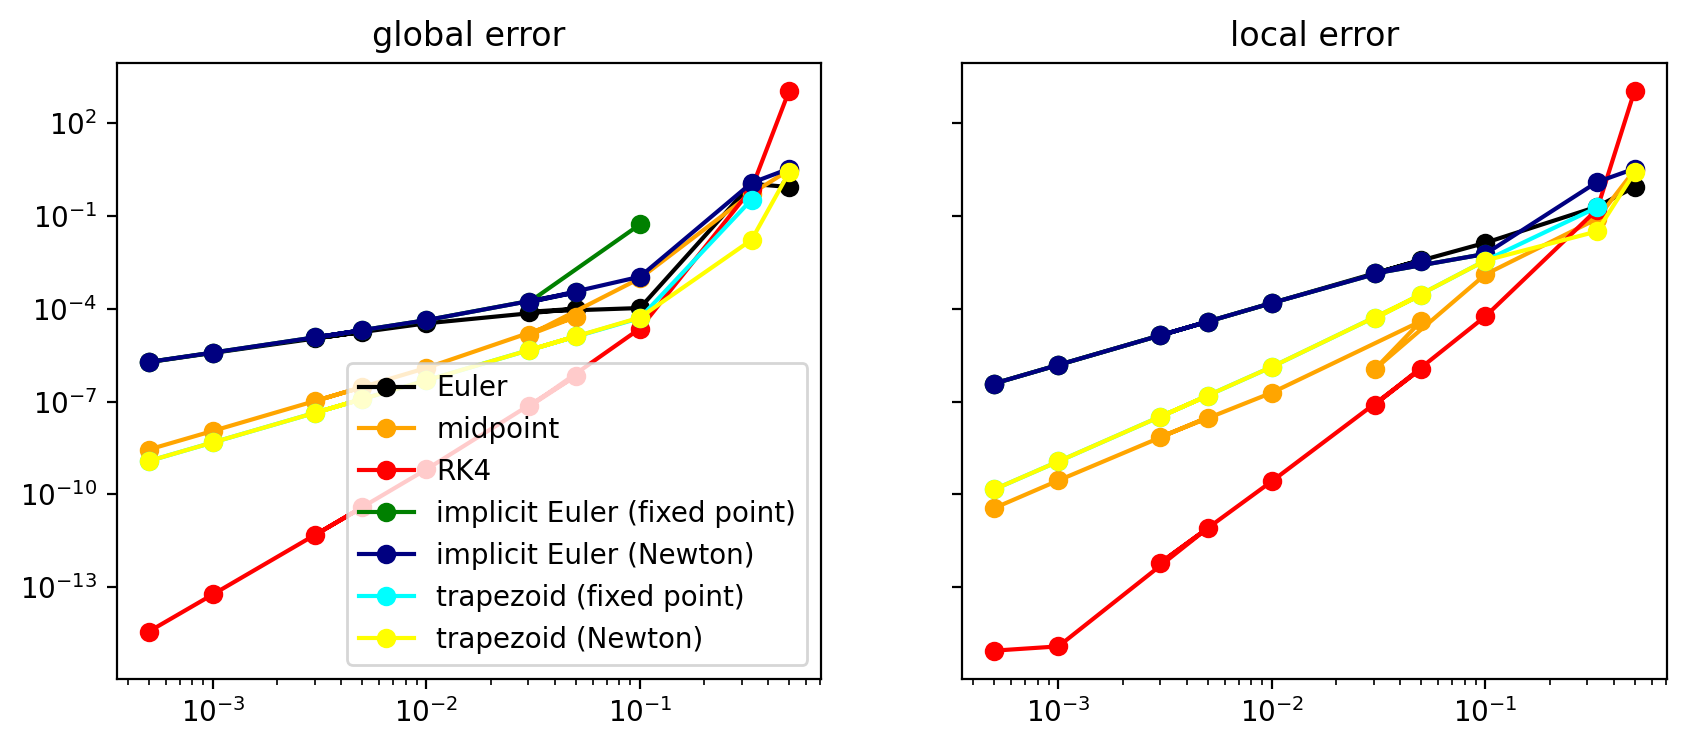

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for method, color in zip(methods.keys(), ["black", "orange", "red", "green", "navy", "cyan", "yellow"]):
    ax[0].plot(H, global_errors[method], "o-", color=color, label=method)

for method, color in zip(methods.keys(), ["black", "orange", "red", "green", "navy", "cyan", "yellow"]):
    ax[1].plot(H, local_errors[method], "o-", color=color)

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")

ax[0].legend()
ax[0].set_title("global error")
ax[1].set_title("local error");

In [13]:
for method in methods.keys():
    ord = np.log(local_errors[method][-4]/local_errors[method][-5]) / np.log(H[-4]/H[-5])
    print(method, "local error order", ord)

Euler local error order 2.002168129151945
midpoint local error order 2.7476263117366084
RK4 local error order 5.045572797670923
implicit Euler (fixed point) local error order 2.003930559211342
implicit Euler (Newton) local error order 2.003930559211342
trapezoid (fixed point) local error order 3.0869939014211605
trapezoid (Newton) local error order 3.0869939014211605


In [14]:
for method in methods.keys():
    ord = np.log(global_errors[method][-4]/global_errors[method][-5]) / np.log(H[-4]/H[-5])
    print(method, "global error order", ord)

Euler global error order 0.9347900914926159
midpoint global error order 2.0576501907626095
RK4 global error order 4.069559803567768
implicit Euler (fixed point) global error order 1.071919717662867
implicit Euler (Newton) global error order 1.0719197161128766
trapezoid (fixed point) global error order 2.0110713229379504
trapezoid (Newton) global error order 2.0110713229379504


For Euler method we observe as expected second order for local error and first order for global error.

For trapezoid method we observe third and second orders for local ang global errors respectively.

Now we run code for $H$ specified in the assignment.

In [15]:
H = [0.3, 0.15, 0.03, 0.01]
N = np.array([int(1/h) for h in H])

N_fixed_point_it = 10
N_Newton_it = 10

methods = {
    "Euler": Euler,
    "midpoint": midpoint,
    "RK4": RK4,
    "implicit Euler (fixed point)": lambda y, t, dt, F: implicit_Euler_fp(y, t, dt, F, N_fixed_point_it),
    "implicit Euler (Newton)": lambda y, t, dt, F: implicit_Euler_Newton(y, t, dt, F, df, N_Newton_it),
    "trapezoid (fixed point)": lambda y, t, dt, F: trapezoid_fp(y, t, dt, F, N_fixed_point_it),
    "trapezoid (Newton)": lambda y, t, dt, F: trapezoid_Newton(y, t, dt, F, df, N_Newton_it),
}

local_errors = {key:[] for key in methods.keys()}
global_errors = {key:[] for key in methods.keys()}

N_it = 10
y0 = 1/2

N_global = 500
t_ = np.linspace(0, 1, N_global)
exact_global = get_exact_solution(t_, N_it)[-1]

for N_t in N:
    t = np.linspace(0, 1, N_t)
    t_ = np.linspace(0, t[1], 100)
    exact_local = get_exact_solution(t_, N_it)[-1]
    for method in methods.keys():
        sol = solve_by_method(y0, t, f, methods[method])
        local_errors[method].append(np.abs(sol[1] -  exact_local))
        global_errors[method].append(np.abs(sol[-1] - exact_global))

H = 1/N

<ipython-input-10-ebdfab81a85c>:2: RuntimeWarning: overflow encountered in scalar power
  return y + 8*y**2 - 9*y**3
<ipython-input-10-ebdfab81a85c>:2: RuntimeWarning: invalid value encountered in scalar subtract
  return y + 8*y**2 - 9*y**3


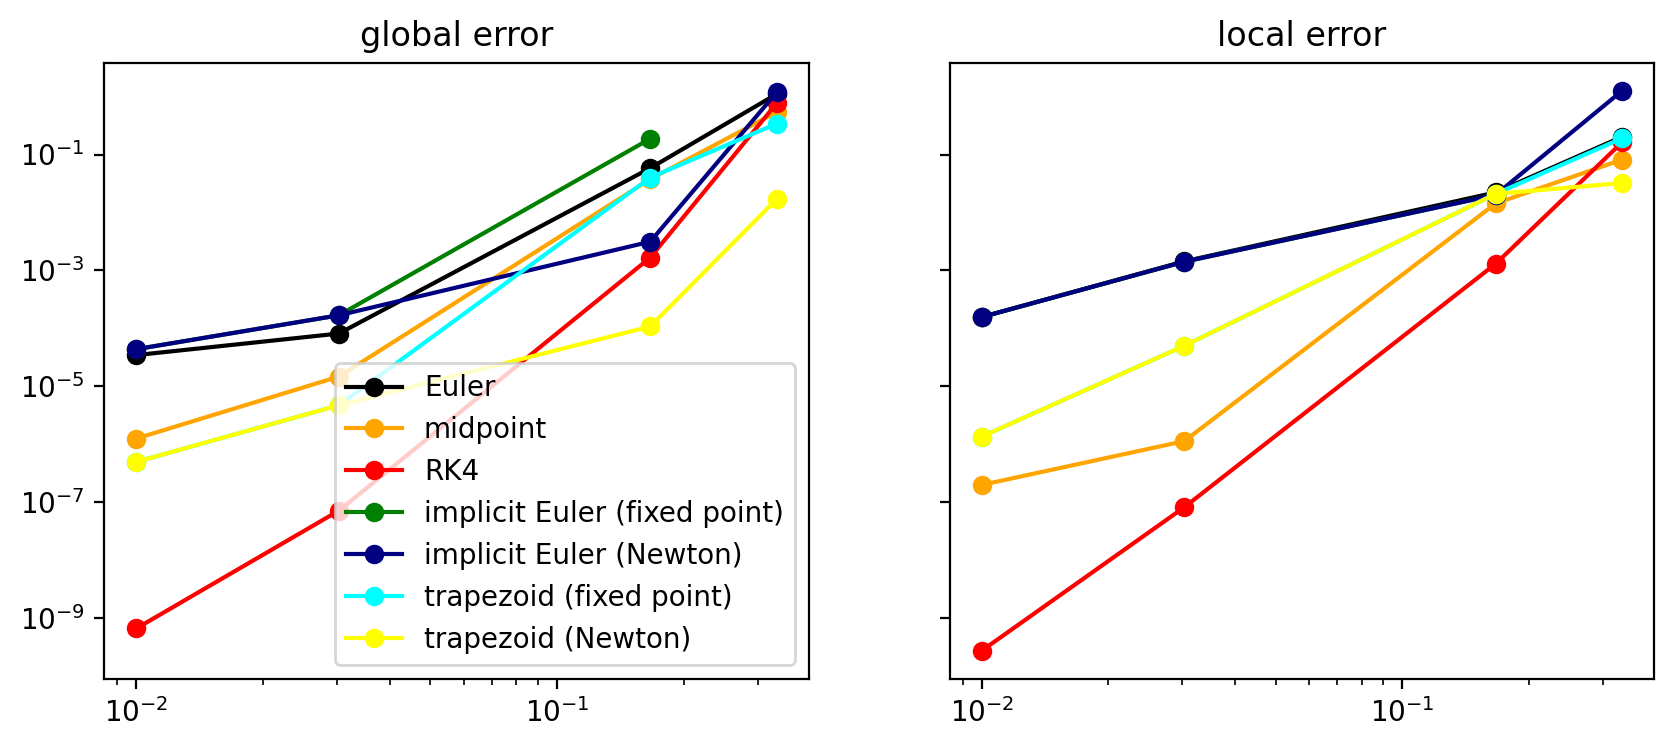

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

for method, color in zip(methods.keys(), ["black", "orange", "red", "green", "navy", "cyan", "yellow"]):
    ax[0].plot(H, global_errors[method], "o-", color=color, label=method)

for method, color in zip(methods.keys(), ["black", "orange", "red", "green", "navy", "cyan", "yellow"]):
    ax[1].plot(H, local_errors[method], "o-", color=color)

for i in range(2):
    ax[i].set_yscale("log")
    ax[i].set_xscale("log")

ax[0].legend()
ax[0].set_title("global error")
ax[1].set_title("local error");

Now lets reproduce Figure 6.22.

It contains comparison of solution with the one obtained by Euler and implicit Euler methods for $h=0.3$ and $h=0.15$.

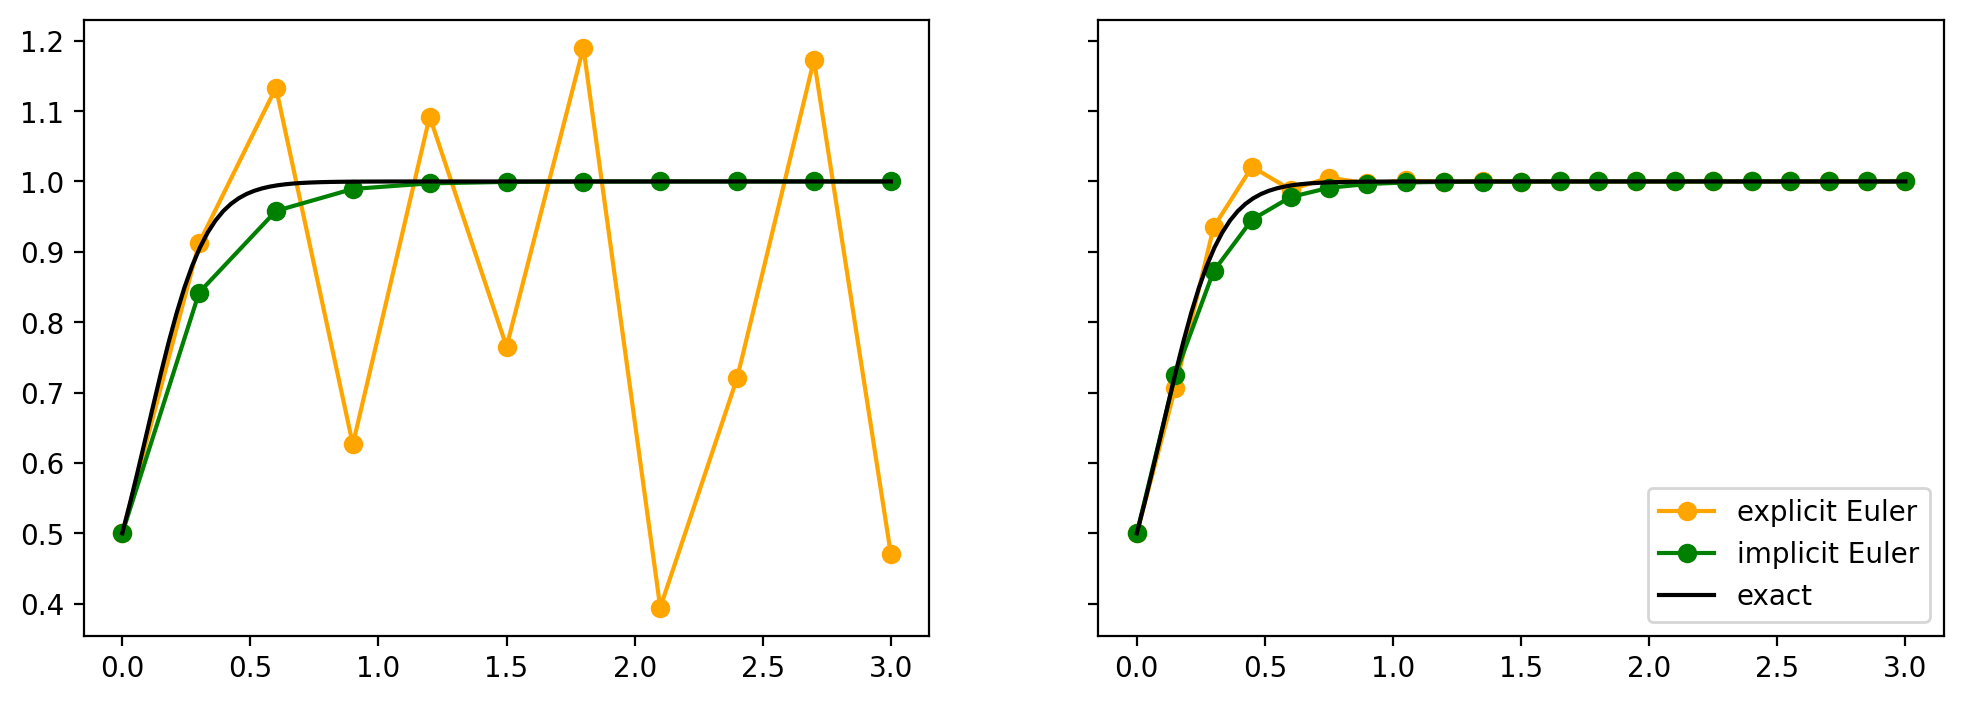

In [17]:
N_t = 100
N_it = 10
T = np.linspace(0, 3, N_t)
exact_solution = get_exact_solution(T, N_it)

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

y0 = 1/2

for i, h in enumerate([0.3, 0.15]):
    N = int(3/h) + 1
    t = np.linspace(0, 3, N)
    sol_explicit_Euler = solve_by_method(y0, t, f, methods["Euler"])
    sol_implicit_Euler = solve_by_method(y0, t, f, methods["implicit Euler (Newton)"])
    ax[i].plot(t, sol_explicit_Euler, "o-", color="orange", label="explicit Euler")
    ax[i].plot(t, sol_implicit_Euler, "o-", color="green", label="implicit Euler")
    ax[i].plot(T, exact_solution, color="black", label="exact")

ax[1].legend(loc=4)

Looks good! Instability for explicit EUler is apparent.

Now to the last question. Why fixed-point iterations diverge when $h=0.3$?

Iteration for our particular ODE read
$$
x^{(i+1)} = x_{n} + \Delta t \left(x^{(i)} + 8\left(x^{(i)}\right)^2 - 9\left(x^{(i)}\right)^3\right).
$$

Suppose we star iterations from $x = 1 + \delta $ for some small $\delta$. We know that $x = 1$ is a steady state, so the expectation is we converge to $x=1$. After first iteration we obtain

$$
x^{(1)} \simeq 1 + \delta + \Delta t \delta \left.(1 + 16 x - 27 x^2)\right|_{x=1} =  1 + \delta - 10 \Delta t \delta.
$$

For $\Delta t = 0.3$ we have

$$
x^{(1)} \simeq 1 - 2 \delta.
$$

We see that error amplifies and changes the sign. If we perform one more iteration we observe

$$
x^{(2)} \simeq 1 + \delta + 6\delta = 1 + 7 \delta.
$$

So the error is not dumped.

Note that this is not the case for $\Delta t = 0.15$ since in this situation

$$
x^{(1)} \simeq 1 + \delta - 1.5 \delta = 1 - 0.5 \delta,
$$

so the error will decrease.

Lets also confirm this numerically.

In [18]:
T = lambda x, dt: 1 + dt*(x + 8*x**2 - 9*x**3)

delta = 1e-3
x1 = 1 + delta
x2 = 1 + delta

for i in range(12):
    x1 = T(x1, 0.3)
    x2 = T(x2, 0.15)
    print(f"Iteration {i+1}: error(0.3) = {x1}, error(0.15) = {x2}")

Iteration 1: error(0.3) = 0.9969942972999999, error(0.15) = 0.9984971486499999
Iteration 2: error(0.3) = 1.0089656861988094, error(0.15) = 1.0022478447050687
Iteration 3: error(0.3) = 0.9726428094157425, error(0.15) = 0.9966138171126198
Iteration 4: error(0.3) = 1.0778608825563816, error(0.15) = 1.0050466479787477
Iteration 5: error(0.3) = 0.7305876983887349, error(0.15) = 0.9923572688454783
Iteration 6: error(0.3) = 1.4473116965517498, error(0.15) = 1.0112982270841282
Iteration 7: error(0.3) = -1.724089586863708, error(0.15) = 0.9826869100641205
Iteration 8: error(0.3) = 21.453778619497335, error(0.15) = 1.0251223729134955
Iteration 9: error(0.3) = -25548.849827300244, error(0.15) = 0.9604963047853199
Iteration 10: error(0.3) = 45029065545086.38, error(0.15) = 1.0548912219890616
Iteration 11: error(0.3) = -2.4651455560132693e+41, error(0.15) = 0.9088527089823882
Iteration 12: error(0.3) = 4.0447479802332124e+124, error(0.15) = 1.1140658935492354


# Problem 3

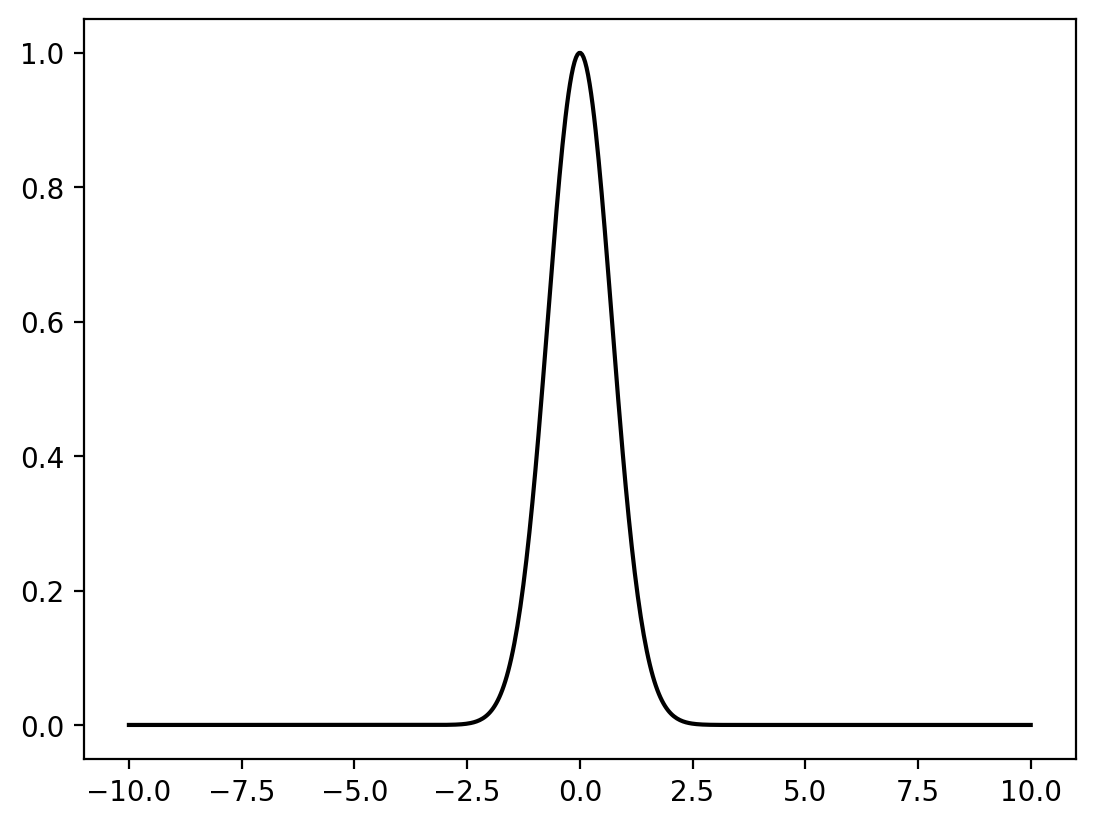

In [19]:
N_x = 600
x = np.linspace(-10, 10, N_x)
y = np.exp(-x**2)

plt.plot(x, y, color="black");

/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.11/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


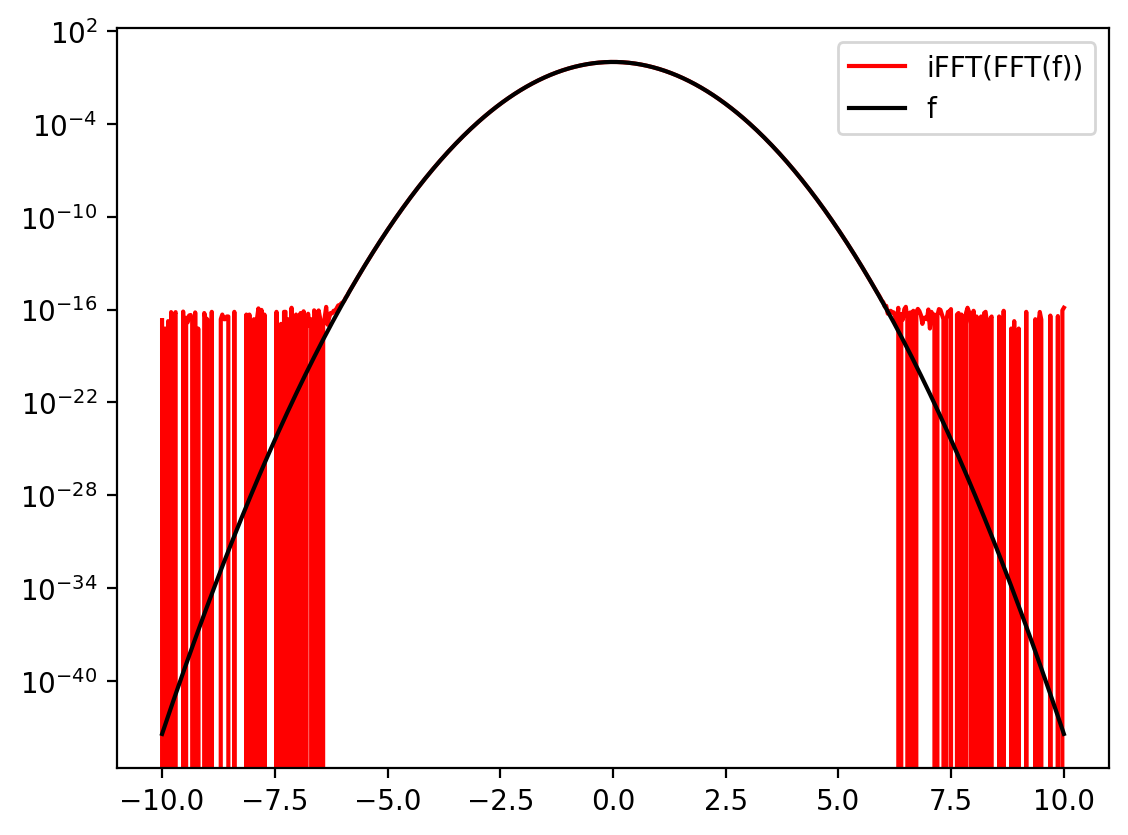

In [20]:
y_ = np.fft.ifft(np.fft.fft(y))

plt.plot(x, y_, color="red", label="iFFT(FFT(f))")
plt.plot(x, y, color="black", label="f")
plt.legend()
plt.yscale("log");

Nothing fascinating to see here. There are round off errors when we apply forward and inverse transforms. These errors are on the level of $10^{-16}$ which is machine epsilon for float64.

To compute cerivatives we will use:
1. $f(x) = \sum_{j} c_{j} e^{2\pi ij x} \Rightarrow f^{'}(x) = \sum_{j} 2\pi ij \left(c_{j} e^{-2\pi ij x}\right)$
2. $f^{'}(x) = \frac{f(x_{i+1}) - f(x_{i})}{x_{i+1} - x_{i}}$ -- first order
3. $f^{'}(x) = \frac{f(x_{i+1}) - f(x_{i-1})}{x_{i+1} - x_{i-1}}$ -- second order

In [21]:
Ns = np.logspace(3, 12, 10, base=2, dtype=int)
error_fft = []
error_fd1 = []
error_fd2 = []

for N in Ns:
    x = np.linspace(-10, 10, N)
    dy = -2*x*np.exp(-x**2)
    y = np.exp(-x**2)
    fft_freq = np.fft.fftfreq(N, d=x[1]-x[0])*2*np.pi*1j
    dy_fft = np.real(np.fft.ifft(np.fft.fft(y)*fft_freq))
    dy_fd1 = (y - np.roll(y, 1))[1:-1] / (x[1] - x[0])
    dy_fd2 = (np.roll(y, -1) - np.roll(y, 1))[1:-1] / (x[2] - x[0])
    error_fft.append(np.linalg.norm(dy_fft - dy) / np.linalg.norm(dy))
    error_fd1.append(np.linalg.norm(dy_fd1 - dy[1:-1]) / np.linalg.norm(dy[1:-1]))
    error_fd2.append(np.linalg.norm(dy_fd2 - dy[1:-1]) / np.linalg.norm(dy[1:-1]))

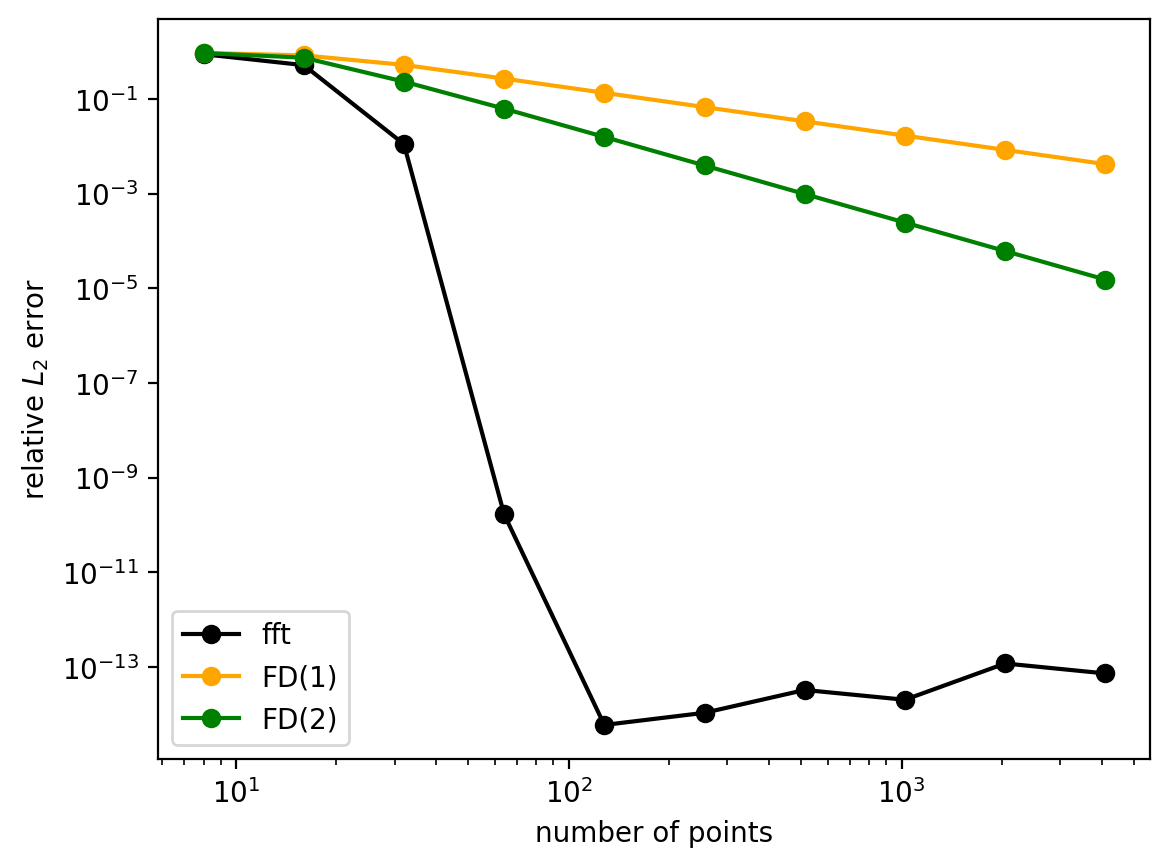

In [22]:
plt.yscale("log")
plt.xscale("log")
plt.plot(Ns, error_fft, "o-", color="black", label="fft")
plt.plot(Ns, error_fd1, "o-", color="orange", label="FD(1)")
plt.plot(Ns, error_fd2, "o-", color="green", label="FD(2)")
plt.xlabel("number of points")
plt.ylabel("relative $L_2$ error")
plt.legend();

In [23]:
fd1_order = -np.log(error_fd1[-2]/error_fd1[-1]) / np.log(Ns[-2]/Ns[-1])
fd2_order = -np.log(error_fd2[-2]/error_fd2[-1]) / np.log(Ns[-2]/Ns[-1])
print("order of FD(1)", fd1_order)
print("order of FD(2)", fd2_order)

order of FD(1) 1.0003380013377647
order of FD(2) 2.0006685427343003


For smooth periodic functions FFT is expected to give spectral accuracy. We see that clearly on the convergence plot.

Finite difference methods have first and second order accuracy as expected.

# Problem 4

Our strategy will be to show that

$$
e^{\Delta t (L + N)} = e^{\frac{\Delta t}{2} L} e^{\Delta tN} e^{\frac{\Delta t}{2} L} + C,
$$

where $C = (\Delta t)^3 \widetilde{C} + \text{higher order terms}$, where $\widetilde{C}$ is some operator that does not depend on $\Delta t$.

We will use [Baker–Campbell–Hausdorff formula](https://en.wikipedia.org/wiki/Baker–Campbell–Hausdorff_formula) without a proof

$$
e^{X}e^{Y} = e^{Z},\,Z = X + Y + \frac{1}{2}[X, Y] + \frac{1}{12}[X, [X, Y]] + \frac{1}{12}[Y, [Y, X]] + \dots.
$$

We collapse two right exponents

$$
e^{\Delta tN} e^{\frac{\Delta t}{2} L} = e^{\Delta tN + \frac{\Delta t}{2} L + \frac{(\Delta t)^2}{4}[N, L] + \frac{(\Delta t)^3}{24}[N, [N, L]] + \frac{(\Delta t)^3}{48} [L, [L, N]] + \dots} \equiv e^{A + \dots}
$$

Doing the same for the remaining exponent:
$$
\log\left(e^{\frac{\Delta t}{2} L} e^{A}\right) = \frac{\Delta t}{2} L + A + \frac{\Delta t}{4}[ L, A] + \frac{\left(\Delta t\right)^3}{48}[L, [L, N]] + \frac{\left(\Delta t\right)^3}{24}\left[N + \frac{1}{2}L, [N, L]\right] + \dots.
$$

Note that other contributions are of order $(\Delta t)^4$ and of no interest to us.

The first term
$$
\frac{\Delta t}{2} L + A = \Delta t (L + N) + \frac{(\Delta t)^2}{4}[N, L] + \frac{(\Delta t)^3}{24}[N, [N, L]] + \frac{(\Delta t)^3}{48} [L, [L, N]] + \dots
$$

Next we simplify commutator
$$
\frac{\Delta t}{4}[L, A] = \frac{(\Delta t)^2}{4}[L, N] + \frac{(\Delta t)^3}{16}[L, [N, L]] + \dots
$$

In the final expression we may have three terms proporitonal to $(\Delta t)^{i},\,i=1, 2, 3$.

Term for $i=1$:
$$
N + L
$$

Term for $i=2$:
$$
[N, L] + [L, N] = 0
$$

Term for $i=3$:
$$
\frac{1}{48}[L, [L, N]] + \frac{1}{24}[N, [N, L]] + \frac{1}{48}[L, [N, L]] + \frac{1}{24}[N, [N, L]] + \frac{1}{48}[L, [L, N]] + \frac{1}{16}[L, [N, L]] = \frac{1}{12}\left([N, [N, L]] + \frac{1}{2}[L, [N, L]]\right).
$$

For now we showed that

$$
e^{\Delta t (L + N)} = e^{\Delta t (L + N) + \frac{(\Delta t)^3}{12}\left([N, [N, L]] + \frac{1}{2}[L, [N, L]]\right) + \dots} + C.
$$

In the next step we expand both $\exp(A)$ as series and observe that all terms smaller than $(\Delta t)^3$ disappear. We can show that as follow
$$
e^{A} - e^{A + B} = (1 + A + \frac{1}{2}A^2 + \frac{1}{6}A^{3} + \dots) - (1 + (A+B) + \frac{1}{2}(A+B)^2 + \frac{1}{6}(A+B)^{3} + \dots) = -B + \dots.
$$
On the right-hand side only $B$ survives since $A \sim \Delta t$ and $B \sim (\Delta t)^3$.

According to our proof

$$
C = \frac{(\Delta t)^3}{12}\left([N, [L, N]] + \frac{1}{2}[L, [L, N]]\right),
$$

which is different from the error term given in teh article. Even if we have mistake somewhere, still we showed that first term is correct and second is absent, so we can be sure that the method has local order at least $3$.

# Problem 5

Here we are asked to implement first and second order splitting methods for nonlinear Schrodinger equation.

First order splitting method
$$
e^{\Delta t (L + N)} \simeq e^{\Delta t L} e^{\Delta t N}
$$

Second order splitting method
$$
e^{\Delta t (L + N)} \simeq e^{\frac{\Delta t}{2} L} e^{\Delta tN} e^{\frac{\Delta t}{2} L}.
$$

In our case
$$
e^{\Delta t L} \Phi = \text{iFFT}\left[ \exp\left(-i k^2 \Delta t\right)\text{FFT}\left[\Phi\right]\right]
$$
and
$$
e^{\Delta t N} \Phi = \exp(i\Delta t\gamma|\Phi|^2) \Phi
$$

We are going to test on soliton
$$
\Phi = \frac{\left(2\lambda\right)^{1/2}\exp\left(i\left(\frac{1}{2}vx + (\lambda - \frac{1}{4}v^2)t + \Phi_0\right)\right)}{\cosh\left((\lambda)^{1/2}(x - vt - x_0)\right)}
$$

Lets start by implementing exact solution.

In [24]:
def get_soliton(x, t, v, lmbd):
    # x0 = Phi0 = 0
    phi = (2*lmbd)**(1/2) * np.exp(1j*(v*x/2 + (lmbd - v**2/4)*t)) / np.cosh(lmbd**(1/2)*(x - v*t))
    return phi

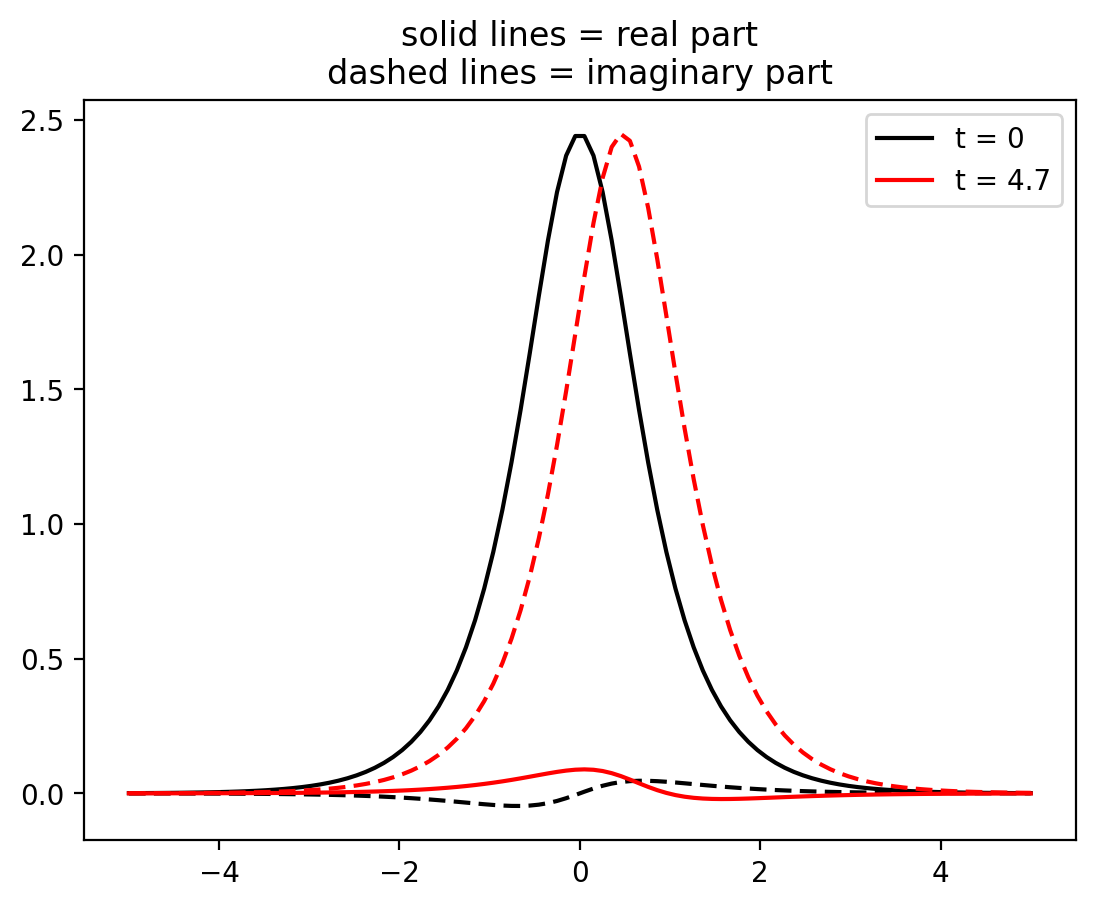

In [25]:
N_x = 100
lmbd = 3
v = 0.1
x = np.linspace(-5, 5, N_x)
t0 = 0
t1 = 4.7
phi_0 = get_soliton(x, t0, v, lmbd)
phi_1 = get_soliton(x, t1, v, lmbd)

plt.plot(x, np.real(phi_0), color="black", label=f"t = {t0}")
plt.plot(x, np.imag(phi_0), color="black", dashes=[4, 2, 4, 2])
plt.plot(x, np.real(phi_1), color="red", label=f"t = {t1}")
plt.plot(x, np.imag(phi_1), color="red", dashes=[4, 2, 4, 2])
plt.legend()
plt.title("solid lines = real part\ndashed lines = imaginary part");

It is moving and oscillationg.

Lets try to implement splitting methods.

In [26]:
def split_1(phi, dt, k):
    phi = np.exp(1j*dt*phi*np.conjugate(phi))*phi
    phi = np.fft.ifft(np.exp(-1j*k**2*dt)*np.fft.fft(phi))
    return phi

def split_2(phi, dt, k):
    phi = np.exp(1j*dt*phi*np.conjugate(phi)/2)*phi
    phi = np.fft.ifft(np.exp(-1j*k**2*dt)*np.fft.fft(phi))
    phi = np.exp(1j*dt*phi*np.conjugate(phi)/2)*phi
    return phi

Sanity check

In [27]:
methods = {
    "split (1)": split_1,
    "split (2)": split_2
}

for method in methods.keys():
    N_x = 500
    lmbd = 10
    v = 0.1
    x = np.linspace(-5, 5, N_x)
    N_t = int(1 / (x[1] - x[0])**2 / np.pi)
    t = np.linspace(0, 1, N_t)
    dt = t[1] - t[0]
    k = np.fft.fftfreq(N_x, d=x[1]-x[0])*2*np.pi
    t0 = 0
    phi = get_soliton(x, t0, v, lmbd)
    trajectory = [phi,]
    exact_sol = [phi,]
    for t_ in t:
        phi = methods[method](trajectory[-1], dt, k)
        trajectory.append(phi)
        exact_sol.append(get_soliton(x, t_, v, lmbd))
    trajectory = np.array(trajectory)
    exact_sol = np.array(exact_sol)
    mean_relative_error = np.mean(np.linalg.norm(trajectory - exact_sol, axis=1, ord=np.inf) / np.linalg.norm(exact_sol, axis=1, ord=np.inf))
    print(f"{method} mean relative error {mean_relative_error}")

split (1) mean relative error 0.013343867130325501
split (2) mean relative error 0.012056072672444126


Ok, relative errors are reasonably small, can try to reproduce convergence plots.

We will compute $L_{\infty}$ norm of error at time $t=1$.

In [29]:
lmbd = 10
v = 0.1

methods = {
    "split (1)": split_1,
    "split (2)": split_2
}

errors = {key:[] for key in methods.keys()}
Ns_t = np.logspace(4, 14, 11, base=2, dtype=int)[5:]

for N_t in Ns_t:
    t = np.linspace(0, 1, N_t)
    dt = t[1] - t[0]
    dx = np.sqrt(np.pi*dt)
    N_x = int(10 / dx) + 2
    x = np.linspace(-5, 5, N_x)
    k = np.fft.fftfreq(N_x, d=x[1]-x[0])*2*np.pi
    for method in methods.keys():
        phi = get_soliton(x, t[0], v, lmbd)
        trajectory = [phi,]
        exact_sol = [phi,]
        for t_ in t[1:]:
            phi = methods[method](trajectory[-1], dt, k)
            trajectory.append(phi)
            exact_sol.append(get_soliton(x, t_, v, lmbd))
        trajectory = np.array(trajectory)
        exact_sol = np.array(exact_sol)
        error = np.linalg.norm(trajectory[-1] - exact_sol[-1], ord=np.inf)
        errors[method].append(error)

for key in errors.keys():
    errors[key] = np.array(errors[key])

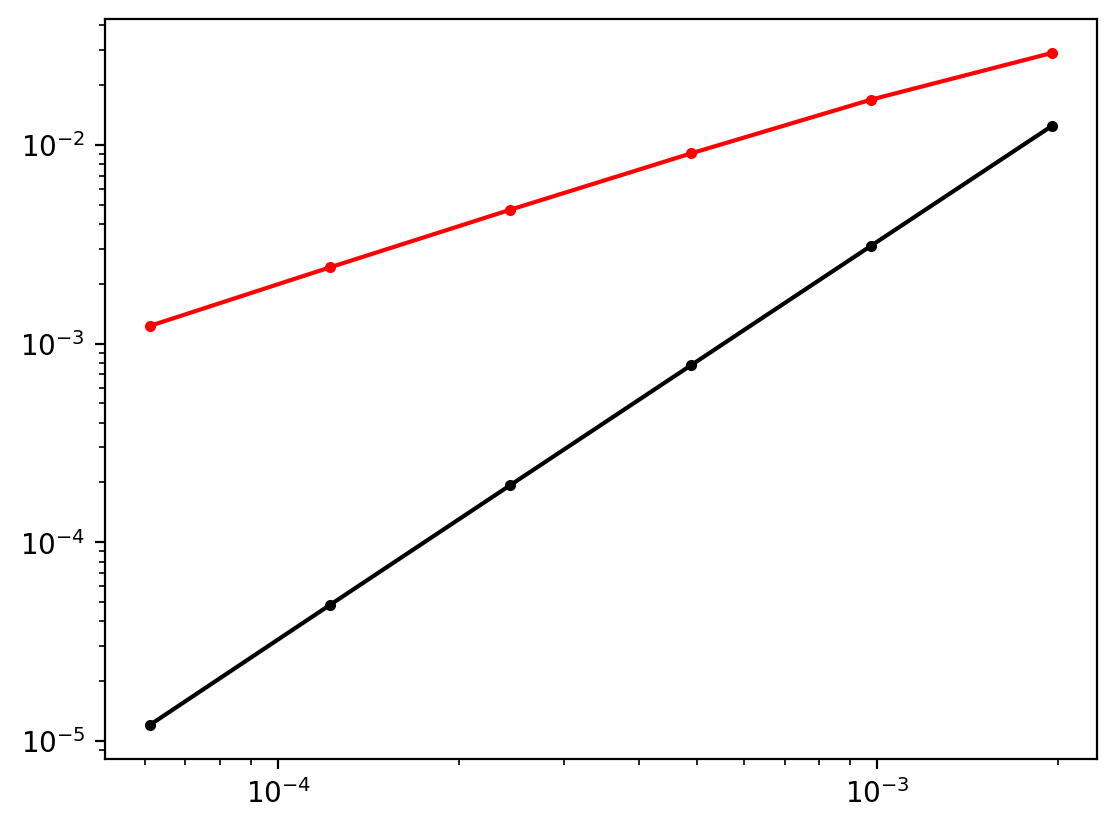

In [30]:
H = 1/ Ns_t
for color, method in zip(["red", "black"], methods.keys()):
    plt.plot(H, errors[method], ".-", color=color)

plt.yscale("log")
plt.xscale("log");

In [31]:
for method in methods.keys():
    ord = np.log(errors[method][-1]/errors[method][-2]) / np.log(H[-1]/H[-2])
    print(method, "global error order", ord)

split (1) global error order 0.9803421231475726
split (2) global error order 2.009982516638188


And we confirt second and first order convergence.